# Preparation

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans

In [2]:
# Load Dataset
data = pd.read_csv('https://raw.githubusercontent.com/dhykac/Airlines_Customer_Clustering/main/airlines_customers.csv')
data.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,210,505308,239560.0,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,140,362480,171483.0,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,135,351159,163618.0,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,23,337314,116350.0,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,152,273844,124560.0,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39


In [3]:
# Data profiling
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          62988 non-null  int64  
 1   FFP_DATE           62988 non-null  object 
 2   FIRST_FLIGHT_DATE  62988 non-null  object 
 3   GENDER             62985 non-null  object 
 4   FFP_TIER           62988 non-null  int64  
 5   WORK_CITY          60719 non-null  object 
 6   WORK_PROVINCE      59740 non-null  object 
 7   WORK_COUNTRY       62962 non-null  object 
 8   AGE                62568 non-null  float64
 9   LOAD_TIME          62988 non-null  object 
 10  FLIGHT_COUNT       62988 non-null  int64  
 11  BP_SUM             62988 non-null  int64  
 12  SUM_YR_1           62437 non-null  float64
 13  SUM_YR_2           62850 non-null  float64
 14  SEG_KM_SUM         62988 non-null  int64  
 15  LAST_FLIGHT_DATE   62988 non-null  object 
 16  LAST_TO_END        629

In [4]:
# Data Numeric
numeric = data.loc[:, (data.dtypes == int) | (data.dtypes == float)].columns.tolist()
numeric

['MEMBER_NO',
 'FFP_TIER',
 'AGE',
 'FLIGHT_COUNT',
 'BP_SUM',
 'SUM_YR_1',
 'SUM_YR_2',
 'SEG_KM_SUM',
 'LAST_TO_END',
 'AVG_INTERVAL',
 'MAX_INTERVAL',
 'EXCHANGE_COUNT',
 'avg_discount',
 'Points_Sum',
 'Point_NotFlight']

In [5]:
# Data Category
category = data.loc[:, (data.dtypes != int) & (data.dtypes != float)].columns.tolist()
category

['FFP_DATE',
 'FIRST_FLIGHT_DATE',
 'GENDER',
 'WORK_CITY',
 'WORK_PROVINCE',
 'WORK_COUNTRY',
 'LOAD_TIME',
 'LAST_FLIGHT_DATE']

# Exploratory Data Analysis

## Statistical Summary

In [6]:
data[numeric].describe()

,MEMBER_NO,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
count,62988.000000,62988.000000,62568.000000,62988.000000,62988.000000,62437.000000,62850.000000,62988.000000,62988.000000,62988.000000,62988.000000,62988.000000,62988.000000,62988.0000,62988.000000
mean,31494.500000,4.102162,42.476346,11.839414,10925.081254,5355.376064,5604.026014,17123.878691,176.120102,67.749788,166.033895,0.319775,0.721558,12545.7771,2.728155
std,18183.213715,0.373856,9.885915,14.049471,16339.486151,8109.450147,8703.364247,20960.844623,183.822223,77.517866,123.397180,1.136004,0.185427,20507.8167,7.364164
min,1.000000,4.000000,6.000000,2.000000,0.000000,0.000000,0.000000,368.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
25%,15747.750000,4.000000,35.000000,3.000000,2518.000000,1003.000000,780.000000,4747.000000,29.000000,23.370370,79.000000,0.000000,0.611997,2775.0000,0.000000
50%,31494.500000,4.000000,41.000000,7.000000,5700.000000,2800.000000,2773.000000,9994.000000,108.000000,44.666667,143.000000,0.000000,0.711856,6328.5000,0.000000
75%,47241.250000,4.000000,48.000000,15.000000,12831.000000,6574.000000,6845.750000,21271.250000,268.000000,82.000000,228.000000,0.000000,0.809476,14302.5000,1.000000
max,62988.000000,6.000000,110.000000,213.000000,505308.000000,239560.000000,234188.000000,580717.000000,731.000000,728.000000,728.000000,46.000000,1.500000,985572.0000,140.000000


From the summary above, we know that :
* In the term of median and mean,
  1. FFP_TIER and avg_discount normally distributed because Mean close to Median
  2. Other column majority positively skewed (Mean > Median) so there is possibility of outlier
* There is customer with `AGE` of 110. It could be anomalies.
* There is 0 value on fare price at `SUM_YR_1` , `SUM_YR_2`, and average discount `avg_discount` which is strage. Need to be analyzed further.

In [7]:
data[category].describe()

,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,LOAD_TIME,LAST_FLIGHT_DATE
count,62988,62988,62985,60719,59740,62962,62988,62988
unique,3068,3406,2,3234,1165,118,1,731
top,1/13/2011,2/16/2013,Male,guangzhou,guangdong,CN,3/31/2014,3/31/2014
freq,184,96,48134,9386,17509,57748,62988,959


From the summary above, we know that :
* Majority of the customers are Male (48.134)
* All columns have large unique values, except `GENDER`

## Missing Value Handling

In [8]:
data_missing_value = data.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value['percentage'] = round((data_missing_value['missing_value']/len(data))*100,3)
data_missing_value = data_missing_value.sort_values('percentage', ascending=False).reset_index(drop=True)
data_missing_value = data_missing_value[data_missing_value['percentage']>0]
data_missing_value

,feature,missing_value,percentage
0,WORK_PROVINCE,3248,5.157
1,WORK_CITY,2269,3.602
2,SUM_YR_1,551,0.875
3,AGE,420,0.667
4,SUM_YR_2,138,0.219
5,WORK_COUNTRY,26,0.041
6,GENDER,3,0.005


There is 6 columns with missing values with highest percentage is `WORK_PROVINCE` column with 5.157% (around 3248 rows). All columns except `WORK_PROVINCE` and `WORK_CITY` have < 1% missing value, so we could drop this. And the other two we could use mode to fill the values. 

In [9]:
# Drop missing values
missing_col = ['SUM_YR_1', 'AGE', 'SUM_YR_2', 'WORK_COUNTRY', 'GENDER']
for col in missing_col:
  data.dropna(subset=[col], inplace=True)

In [10]:
# Fill missing values
data['WORK_CITY'].fillna(data['WORK_CITY'].mode()[0], inplace=True)
data['WORK_PROVINCE'].fillna(data['WORK_PROVINCE'].mode()[0], inplace=True)

In [11]:
data_missing_value = data.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value

,feature,missing_value
0,MEMBER_NO,0
1,FFP_DATE,0
2,FIRST_FLIGHT_DATE,0
3,GENDER,0
4,FFP_TIER,0
5,WORK_CITY,0
6,WORK_PROVINCE,0
7,WORK_COUNTRY,0
8,AGE,0
9,LOAD_TIME,0


## Anomalies Handling

It can be seen in the `LAST_FLIGHT_DATE` column that there is value 2014/2/29. This will be an anomaly because there is no such date at 2014.

In [12]:
data[data.LAST_FLIGHT_DATE.str.contains('2014/2/29')]

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
248,56497,6/17/2007,6/17/2007,Female,6,guangzhou,guangdong,CN,46.0,3/31/2014,53,116307,30884.0,70845.0,85000,2014/2/29 0:00:00,32,13.250000,57,0,1.373478,132653,4
447,17306,8/26/2009,4/29/2010,Male,5,haerbin,heilongjiang,CN,70.0,3/31/2014,31,96739,26510.0,46323.0,69453,2014/2/29 0:00:00,32,22.766667,75,6,1.375395,101413,7
473,915,11/10/2006,1/26/2007,Male,5,.,beijing,CN,39.0,3/31/2014,49,84754,28693.0,30580.0,65717,2014/2/29 0:00:00,32,14.250000,65,1,1.425974,93153,8
832,20336,7/13/2005,8/6/2005,Male,5,guangzhou,guangdong,CN,40.0,3/31/2014,80,61418,32900.0,36417.0,114222,2014/2/29 0:00:00,32,8.696203,34,2,0.664970,91476,15
1051,62884,5/24/2006,4/21/2007,Male,5,wuhan,hubei,CN,50.0,3/31/2014,27,65918,23892.0,35680.0,49859,2014/2/29 0:00:00,32,19.115385,72,4,1.388584,69047,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61539,55995,1/11/2013,7/10/2013,Male,4,dalianshi,liaoning,CN,23.0,3/31/2014,3,0,0.0,955.0,3513,2014/2/29 0:00:00,32,117.000000,211,0,0.276667,0,0
61871,48742,7/26/2009,7/26/2009,Male,4,tianjin,tianjin,CN,37.0,3/31/2014,2,854,0.0,966.0,1298,2014/2/29 0:00:00,32,135.000000,135,0,0.690000,1094,1
61909,9190,4/11/2011,4/20/2011,Male,4,guangzhou,guangdong,CN,34.0,3/31/2014,2,838,0.0,853.0,2595,2014/2/29 0:00:00,32,1.000000,1,0,0.340000,3356,19
62721,38776,10/31/2007,3/13/2008,Male,4,foshan,guangdong,CN,42.0,3/31/2014,2,276,0.0,688.0,1199,2014/2/29 0:00:00,32,78.000000,78,0,0.489525,276,0


In [13]:
# Checking Percentage
print('Incorrect `LAST_FLIGHT_DATE` data percentage: ', end='\n\n')
print(str(round(data[data.LAST_FLIGHT_DATE.str.contains('2014/2/29')]['LAST_FLIGHT_DATE'].count()/len(data), 3)), '%')

Incorrect `LAST_FLIGHT_DATE` data percentage: 

0.007 %


Because of small percentage, we could drop this.

In [14]:
data.drop(data[data.LAST_FLIGHT_DATE.str.contains('2014/2/29')].index, inplace = True)

print(data[data.LAST_FLIGHT_DATE.str.contains('2014/2/29')]['LAST_FLIGHT_DATE'].count())

0


Now lets handle this strangely old customers.

In [15]:
# AGE 110 check
data[data.AGE > 100]

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
23268,20264,4/14/2005,5/18/2005,Female,4,shenzhenshi,guangdong,CN,110.0,3/31/2014,7,10895,6117.0,2888.0,14053,4/6/2013,361,50.333333,214,1,0.740881,11194,3


In [16]:
# AGE 110 handling
data.drop(data[data.AGE > 100].index, inplace = True)

Lastly we should handle `avg_discount`, `SUM_YR_1`, and `SUM_YR_2` with 0 values. Also we add `SEG_KM_SUM` > 0 , which is the indicator why they are anomalies. To be clear, how could someone who already had flight records (`SEG_KM_SUM`) but didn't pay anything? (`avg_discount`,`SUM_YR_1`,`SUM_YR_2`). OFC, assuming all of the customers are not VVIP customers.

In [17]:
# 0 Values check
data[(data.SUM_YR_1 == 0) & (data.SUM_YR_2 == 0) & (data.avg_discount == 0) & (data.SEG_KM_SUM > 0)]

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
62980,1761,8/7/2012,9/9/2012,Female,4,shenzhen,guangdong,CN,29.0,3/31/2014,2,0,0.0,0.0,6138,9/21/2012,558,12.0,12,0,0.0,0,0
62981,15206,12/2/2011,12/2/2011,Female,4,guangzhou,guangdong,CN,42.0,3/31/2014,2,0,0.0,0.0,2158,10/6/2013,178,3.0,3,0,0.0,0,0
62982,16415,1/20/2013,1/20/2013,Female,4,beijing,.,CN,35.0,3/31/2014,2,0,0.0,0.0,3848,1/20/2013,437,0.0,0,0,0.0,0,0
62983,18375,5/20/2011,6/5/2013,Female,4,guangzhou,guangdong,CN,25.0,3/31/2014,2,0,0.0,0.0,1134,6/9/2013,297,4.0,4,1,0.0,12318,22
62984,36041,3/8/2010,9/14/2013,Male,4,foshan,guangdong,CN,38.0,3/31/2014,4,0,0.0,0.0,8016,1/3/2014,89,37.0,60,14,0.0,106972,43
62985,45690,3/30/2006,12/2/2006,Female,4,guangzhou,guangdong,CN,43.0,3/31/2014,2,0,0.0,0.0,2594,3/3/2014,29,166.0,166,0,0.0,0,0
62986,61027,2/6/2013,2/14/2013,Female,4,guangzhou,guangdong,CN,36.0,3/31/2014,2,0,0.0,0.0,3934,2/26/2013,400,12.0,12,0,0.0,0,0


In [18]:
# Just 7 rows, then we drop it.
data.drop(data[(data.SUM_YR_1 == 0) & (data.SUM_YR_2 == 0) & (data.avg_discount == 0) & (data.SEG_KM_SUM > 0)].index, inplace = True)

## Data Types Handling

In [19]:
# Change AGE to int64
data['AGE'] = data['AGE'].astype(int) 

# Change Date columns to Datetime
date_col = ['FFP_DATE', 'FIRST_FLIGHT_DATE', 'LOAD_TIME','LAST_FLIGHT_DATE']
for col in date_col:
  data[col] = pd.to_datetime(data[col])

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61429 entries, 0 to 62978
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   MEMBER_NO          61429 non-null  int64         
 1   FFP_DATE           61429 non-null  datetime64[ns]
 2   FIRST_FLIGHT_DATE  61429 non-null  datetime64[ns]
 3   GENDER             61429 non-null  object        
 4   FFP_TIER           61429 non-null  int64         
 5   WORK_CITY          61429 non-null  object        
 6   WORK_PROVINCE      61429 non-null  object        
 7   WORK_COUNTRY       61429 non-null  object        
 8   AGE                61429 non-null  int64         
 9   LOAD_TIME          61429 non-null  datetime64[ns]
 10  FLIGHT_COUNT       61429 non-null  int64         
 11  BP_SUM             61429 non-null  int64         
 12  SUM_YR_1           61429 non-null  float64       
 13  SUM_YR_2           61429 non-null  float64       
 14  SEG_KM

## Numeric Distribution and Outliers Check

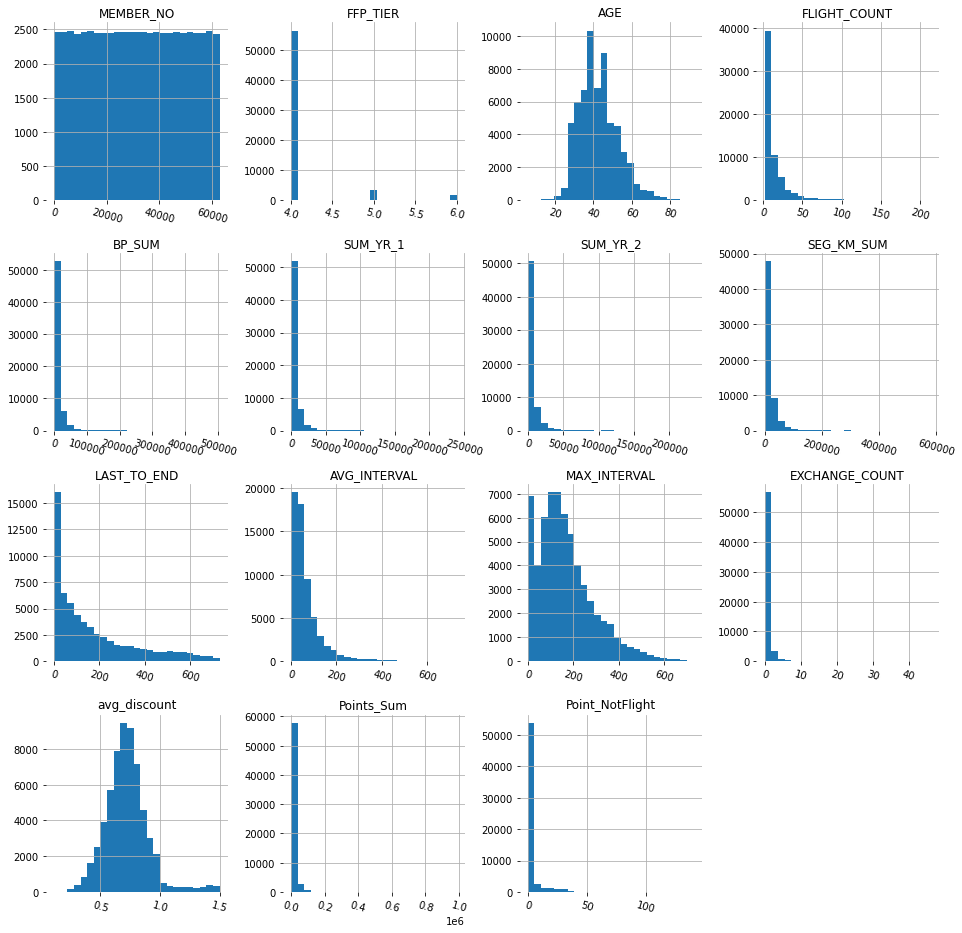

In [21]:
h = data.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

`FFP_TIER` and `avg_discount` normally distributed because Mean close to Median, and the other columns majority positively skewed (Mean > Median) so there is possibility of an outlier.

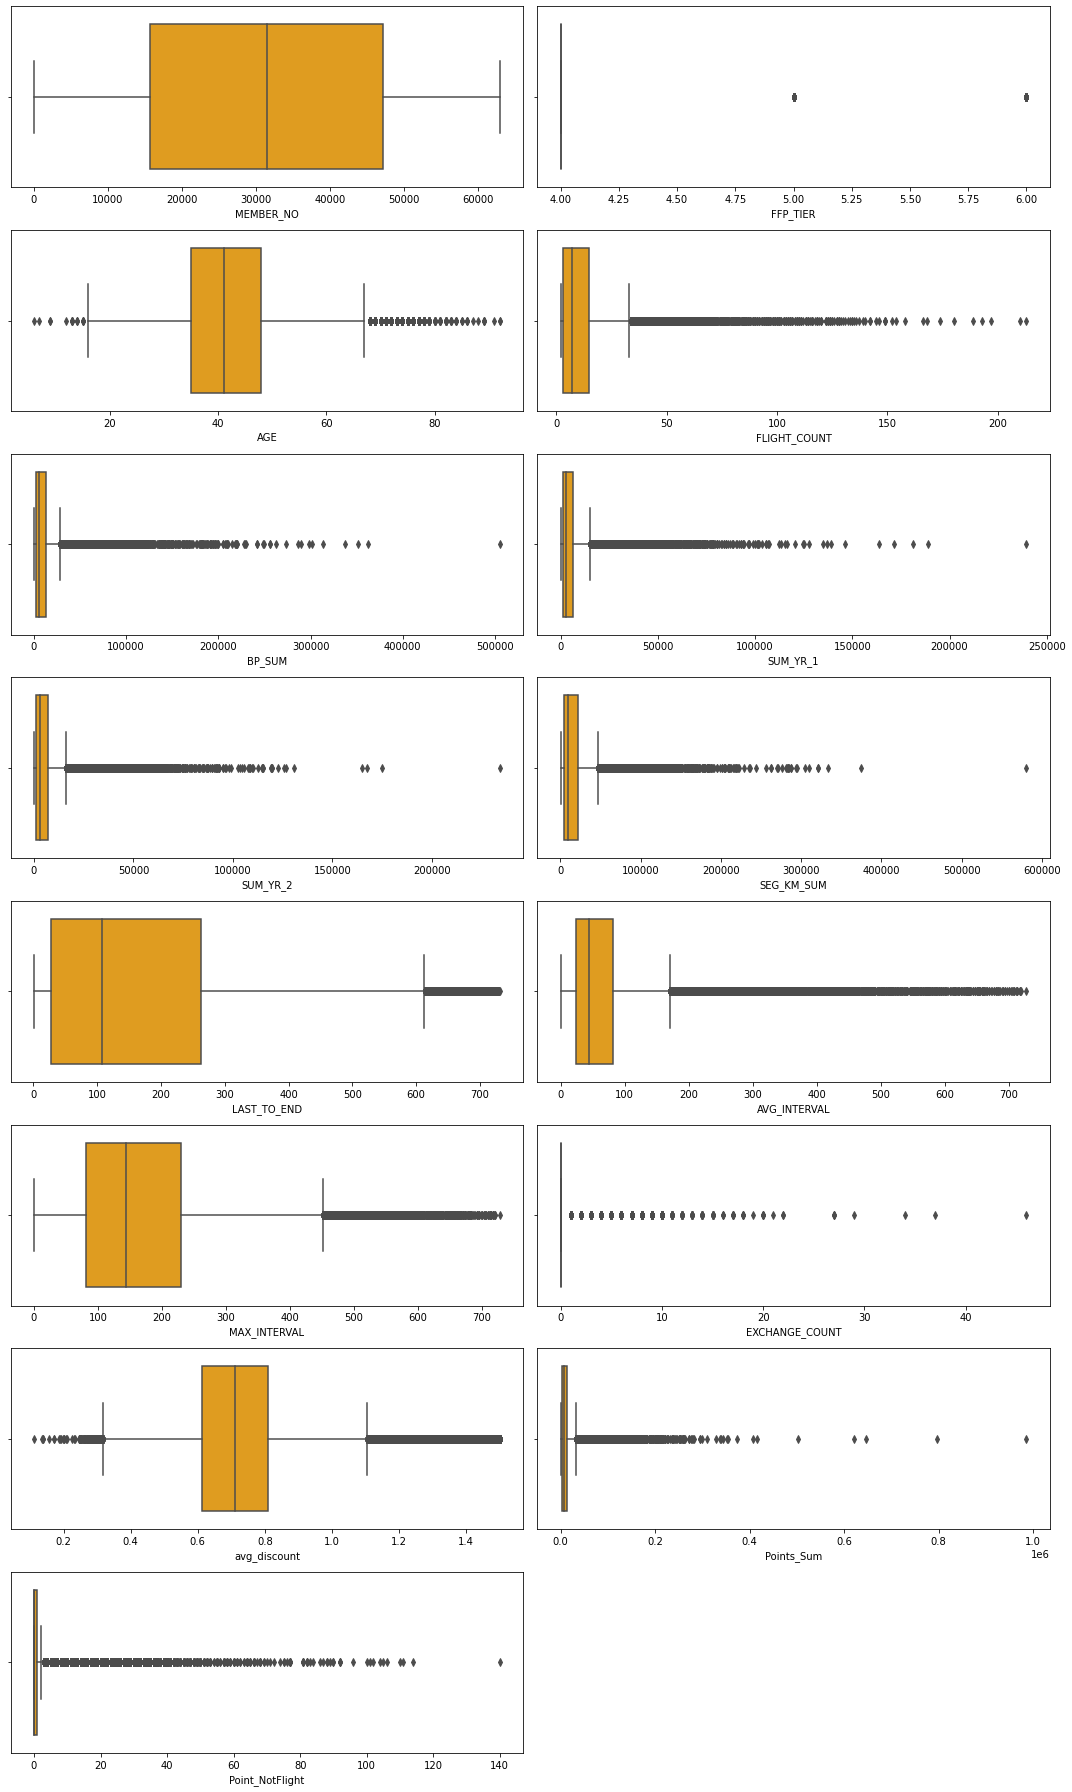

In [22]:
plt.figure(figsize=(15, 25))
for i in range(0, len(numeric)):
    plt.subplot(8, 2, i+1)
    sns.boxplot(x=data[numeric[i]], color='orange')
    plt.tight_layout()

plt.show()

All of the columns have an outliers except `FFP_TIER`.

## Correlation Matrix

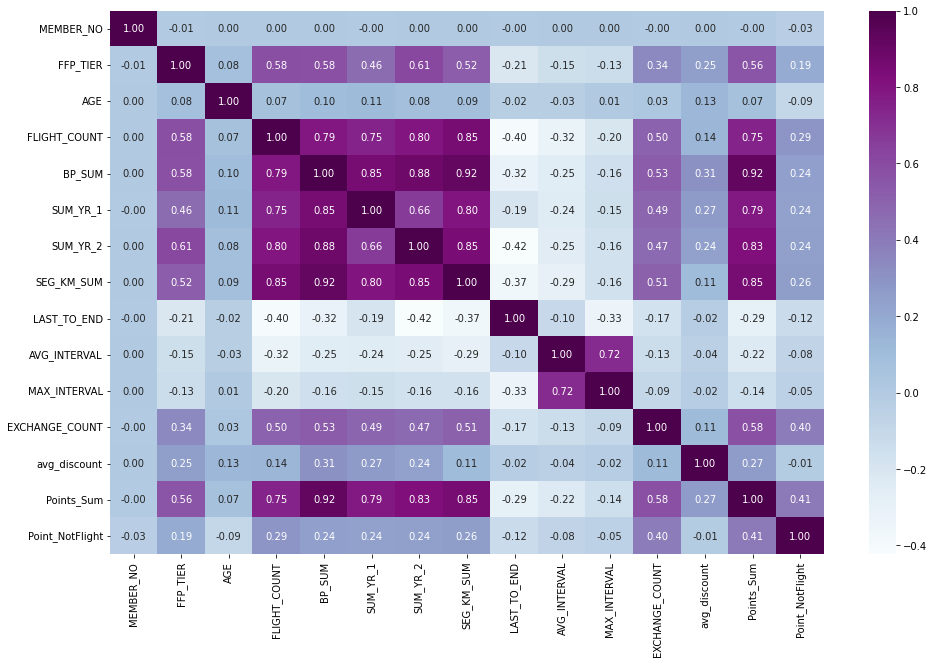

In [23]:
corr_= data.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")

With the threshold assume 80% are high correlation. We could find that :
* `BP_SUM` with `SEG_KM_SUM` and `BP_SUM` with `Points_Sum` = 0.92
* `BP_SUM` with `SUM_YR_2` = 0.88
* `FLIGHT_COUNT` with `SEG_KM_SUM` , `BP_SUM` with `SUM_YR_1`, `SUM_YR_2` with `SEG_KM_SUM`, 'SEG_KM_SUM` with `Points_Sum` = 0.85
* `SUM_YR_2` with `Points_Sum` = 0.83

# Feature Engineering and Selection

From the independent research, i found that there is an easy way to clustering business customers, and that's RFM methods. Where RFM stands for :
* R (Recency) indicates freshness customers activity. In this dataset, the feature will be `LAST_TO_END` which is distance from last flight time until newly flight order.
* F (Frequency) indicates how much a customers do their buying. In this dataset, the feature will be `FLIGHT_COUNT` which is number of a customer flights.
* M (Monetary) indicates the customers buying powers. In this dataset the feature will be `SEG_KM_SUM` which is accumulate flight hours of customers. This because we didn't know how much total or average buying power of the customers so we need a further knowledge about the market we trying to research.

In addition of that, how about we do a further research and added two more feature that indicates customers value like :
* Loyalty that indicates how long the customers stay buying from the company. We need to engineering this feature which values is the duration of membership.
* Class that indicates discount related to class, that reflect customers value based on discount the customers get on every cabin class. In this dataset, the feature will be `avg_discount`

Now, let's move on.

In [24]:
# Feature Engineering for loyalty
data['MEMBER_DUR_MONTHS'] = ((data['LOAD_TIME'] - data['FFP_DATE'])/np.timedelta64(1, 'M'))
data['MEMBER_DUR_MONTHS'] = data['MEMBER_DUR_MONTHS'].astype(int)

data.sample(5)

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,MEMBER_DUR_MONTHS
59668,7997,2012-05-17,2013-03-30,Male,4,shenyangshi,liaoningsheng,CN,20,2014-03-31,2,321,387.0,785.0,3572,2013-07-17,259,109.000000,109,0,0.367716,321,0,22
54547,33731,2012-07-18,2012-07-18,Male,4,ouhai,zhejiang,CN,46,2014-03-31,3,1860,1968.0,0.0,3030,2012-08-07,603,10.000000,10,0,0.683333,1860,0,20
23285,17946,2006-09-12,2007-08-23,Female,4,haerbin,heilongjiang,CN,62,2014-03-31,10,9444,1669.0,3466.0,13376,2014-03-18,14,47.000000,160,0,0.777813,9444,0,90
14685,37532,2011-03-21,2011-04-07,Male,4,guangzhou,guangdong,CN,33,2014-03-31,24,12967,7825.0,8148.0,24912,2014-03-21,11,25.260870,94,3,0.650980,27725,31,36
1121,18848,2006-06-05,2006-07-09,Male,5,guangzhou,guangzhou,CN,53,2014-03-31,63,52669,29631.0,29435.0,101041,2014-03-30,2,11.451613,46,5,0.665195,65046,7,93


In [25]:
# Feature Selection
df_select = data.copy()
df_select = df_select[['MEMBER_DUR_MONTHS','LAST_TO_END','FLIGHT_COUNT','SEG_KM_SUM','avg_discount']]
df_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61429 entries, 0 to 62978
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_DUR_MONTHS  61429 non-null  int64  
 1   LAST_TO_END        61429 non-null  int64  
 2   FLIGHT_COUNT       61429 non-null  int64  
 3   SEG_KM_SUM         61429 non-null  int64  
 4   avg_discount       61429 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 2.8 MB


In [26]:
df_select.describe()

,MEMBER_DUR_MONTHS,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,avg_discount
count,61429.000000,61429.000000,61429.000000,61429.000000,61429.000000
mean,48.215761,173.550245,11.940956,17277.610917,0.721726
std,27.818950,181.473954,14.119509,21055.460423,0.184697
min,11.000000,1.000000,2.000000,368.000000,0.112043
25%,24.000000,28.000000,3.000000,4850.000000,0.612569
50%,41.000000,107.000000,7.000000,10150.000000,0.711807
75%,71.000000,262.000000,15.000000,21433.000000,0.808997
max,112.000000,731.000000,213.000000,580717.000000,1.500000


# K-Means

## Scaling

In this session, we will scaling the feature normalize `MEMBER_DUR_MONTHS`, `LAST_TO_END`, `FLIGHT_COUNT`, and `SEG_KM_SUM` columns. And `avg_discount` using standardization. This would be different because `avg_discount` have normal distribution while the others not.

In [27]:
# Normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

norm_col = ['MEMBER_DUR_MONTHS', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM']

for col in norm_col:
  df_select[col + '_NORM'] = MinMaxScaler().fit_transform(df_select[col].values.reshape(len(df_select), 1))

# Standardization
df_select['avg_discount_STD'] = StandardScaler().fit_transform(df_select['avg_discount'].values.reshape(len(df_select), 1))

In [28]:
df_select.describe()

,MEMBER_DUR_MONTHS,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,avg_discount,MEMBER_DUR_MONTHS_NORM,LAST_TO_END_NORM,FLIGHT_COUNT_NORM,SEG_KM_SUM_NORM,avg_discount_STD
count,61429.000000,61429.000000,61429.000000,61429.000000,61429.000000,61429.000000,61429.000000,61429.000000,61429.000000,6.142900e+04
mean,48.215761,173.550245,11.940956,17277.610917,0.721726,0.368473,0.236370,0.047114,0.029137,1.905855e-15
std,27.818950,181.473954,14.119509,21055.460423,0.184697,0.275435,0.248594,0.066917,0.036281,1.000008e+00
min,11.000000,1.000000,2.000000,368.000000,0.112043,0.000000,0.000000,0.000000,0.000000,-3.301023e+00
25%,24.000000,28.000000,3.000000,4850.000000,0.612569,0.128713,0.036986,0.004739,0.007723,-5.910148e-01
50%,41.000000,107.000000,7.000000,10150.000000,0.711807,0.297030,0.145205,0.023697,0.016855,-5.370799e-02
75%,71.000000,262.000000,15.000000,21433.000000,0.808997,0.594059,0.357534,0.061611,0.036297,4.725116e-01
max,112.000000,731.000000,213.000000,580717.000000,1.500000,1.000000,1.000000,1.000000,1.000000,4.213829e+00


In [29]:
df_select_std = df_select.copy()
df_select_std = df_select_std[['MEMBER_DUR_MONTHS_NORM', 'LAST_TO_END_NORM', 'FLIGHT_COUNT_NORM', 'SEG_KM_SUM_NORM', 'avg_discount_STD']]

In [30]:
df_select_std.sample(5)

,MEMBER_DUR_MONTHS_NORM,LAST_TO_END_NORM,FLIGHT_COUNT_NORM,SEG_KM_SUM_NORM,avg_discount_STD
45363,0.544554,0.127397,0.000000,0.006432,0.791779
12097,0.495050,0.015068,0.042654,0.022981,3.592894
40544,0.495050,0.372603,0.014218,0.010025,0.055326
13820,0.584158,0.076712,0.056872,0.031531,1.046835
62944,0.960396,0.071233,0.000000,0.000965,-2.066791


## Find the best K

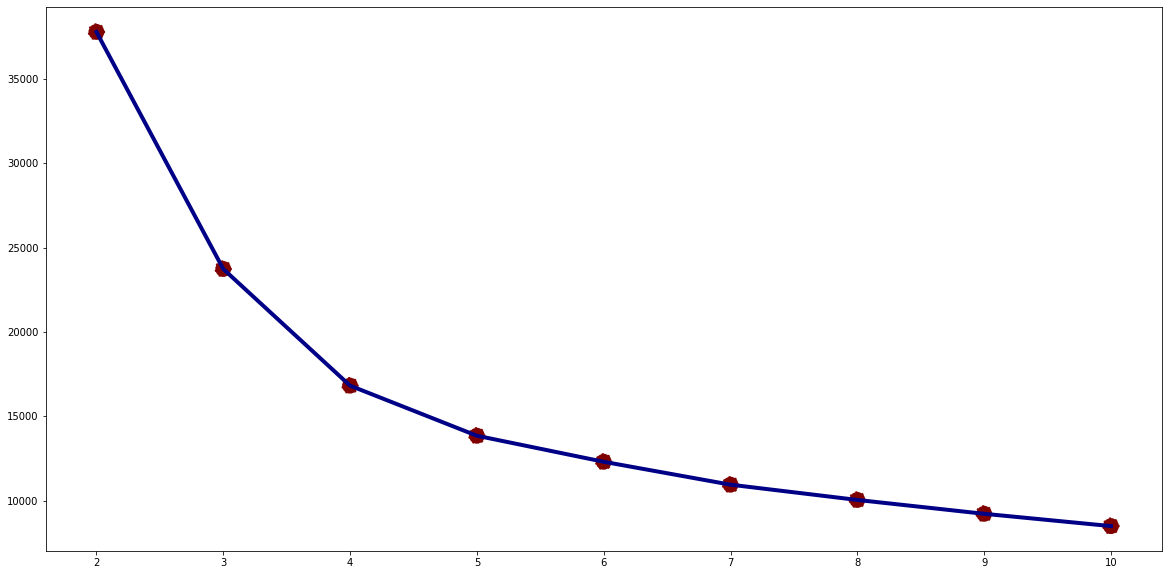

In [31]:
# Inertia
from sklearn.cluster import KMeans
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_select_std)
    inertia.append(kmeans.inertia_)



plt.figure(figsize=(20, 10))

sns.lineplot(x=range(2, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 11), y=inertia, s=300, color='#800000',  linestyle='--')
plt.show()

From the inertia above, we can see that K = 3 and K = 4 most likely the best K because there isn't significant decrease for the next K.

## Modeling

In [32]:
# From the inertia, we decide to choose number 3 since it's more like the start of stable decrease from the values.
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_select_std)

In [33]:
# Made ane array of cluster labels
clusters = kmeans.labels_

In [34]:
# Assign labels to dataframe
data['clusters'] = clusters
data.head(5)

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,MEMBER_DUR_MONTHS,clusters
0,54993,2006-11-02,2008-12-24,Male,6,.,beijing,CN,31,2014-03-31,210,505308,239560.0,234188.0,580717,2014-03-31,1,3.483254,18,34,0.961639,619760,50,88,1
1,28065,2007-02-19,2007-08-03,Male,6,guangzhou,beijing,CN,42,2014-03-31,140,362480,171483.0,167434.0,293678,2014-03-25,7,5.194245,17,29,1.252314,415768,33,85,2
2,55106,2007-02-01,2007-08-30,Male,6,.,beijing,CN,40,2014-03-31,135,351159,163618.0,164982.0,283712,2014-03-21,11,5.298507,18,20,1.254676,406361,26,85,2
3,21189,2008-08-22,2008-08-23,Male,5,Los Angeles,CA,US,64,2014-03-31,23,337314,116350.0,125500.0,281336,2013-12-26,97,27.863636,73,11,1.090870,372204,12,67,2
4,39546,2009-04-10,2009-04-15,Male,6,guiyang,guizhou,CN,48,2014-03-31,152,273844,124560.0,130702.0,309928,2014-03-27,5,4.788079,47,27,0.970658,338813,39,59,1


## Cluster Analysis

In [35]:
df_select_std

,MEMBER_DUR_MONTHS_NORM,LAST_TO_END_NORM,FLIGHT_COUNT_NORM,SEG_KM_SUM_NORM,avg_discount_STD
0,0.762376,0.000000,0.985782,1.000000,1.298967
1,0.732673,0.008219,0.654028,0.505403,2.872778
2,0.732673,0.013699,0.630332,0.488230,2.885562
3,0.554455,0.131507,0.099526,0.484136,1.998663
4,0.475248,0.005479,0.710900,0.533403,1.347798
...,...,...,...,...,...
62974,0.940594,0.120548,0.000000,0.000000,-0.063489
62975,0.524752,0.164384,0.000000,0.000000,-0.280063
62976,0.326733,0.052055,0.000000,0.001196,-2.689438
62977,0.039604,0.634247,0.000000,0.000924,-2.554080


In [36]:
pca = PCA(n_components=4)

pca.fit(df_select_std)
pcs = pca.transform(df_select_std)

In [37]:
print('Explained variance:', pca.explained_variance_)
print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance: [1.00066913 0.07964761 0.05852904 0.00433134]
Explained variance ratio: [0.875113   0.06965406 0.05118527 0.00378788]


<BarContainer object of 4 artists>

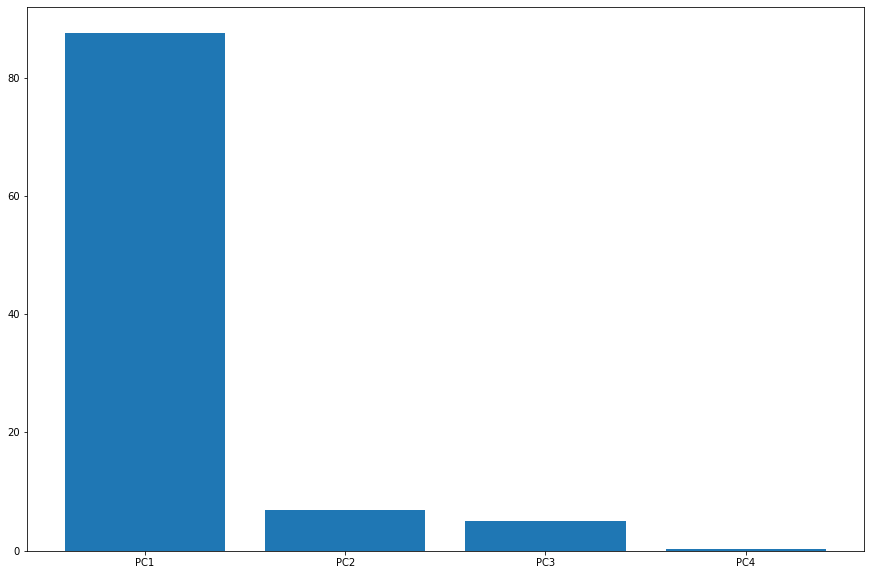

In [38]:
fig, ax = plt.subplots(figsize=(15,10))
plt.bar(['PC1', 'PC2', 'PC3', 'PC4'], pca.explained_variance_ratio_ * 100)

From the plot above, we decide to choose `n_compenents=2` in order to maintain as much as possible informatiuon of the data.

In [39]:
pca = PCA(n_components=2)

pca.fit(df_select_std)
pcs = pca.transform(df_select_std)

data_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
data_pca['clusters'] = clusters
data_pca.head()

,PC 1,PC 2,clusters
0,1.322036,0.536434,1
1,2.889383,0.421894,2
2,2.901836,0.416626,2
3,2.005285,0.185232,2
4,1.359489,0.235990,1


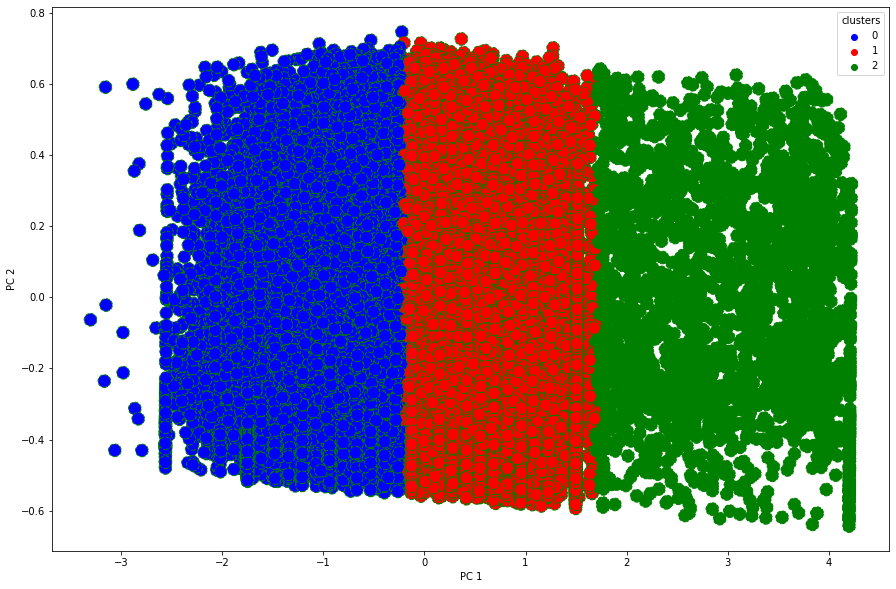

In [40]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="clusters",
    edgecolor='green',
    linestyle='--',
    data=data_pca,
    palette=['blue','red','green'],
    s=160,
    ax=ax
)

plt.show()

In [41]:
display(data.groupby('clusters').agg(['mean','median']))

MEMBER_NO           FFP_TIER  ... Point_NotFlight MEMBER_DUR_MONTHS       
                  mean   median      mean  ...          median              mean median
clusters                                   ...                                         
0         31392.144646  31391.0  4.034277  ...               0         46.332954     39
1         31574.968874  31598.0  4.121630  ...               0         49.088256     43
2         31277.445349  30948.5  4.546899  ...               0         55.513953     53

[3 rows x 32 columns]

## RFM + Loyalty & Class analysis

In [42]:
rfmlc = ['MEMBER_DUR_MONTHS','LAST_TO_END','FLIGHT_COUNT','SEG_KM_SUM','avg_discount', 'clusters']
rfmlc

['MEMBER_DUR_MONTHS',
 'LAST_TO_END',
 'FLIGHT_COUNT',
 'SEG_KM_SUM',
 'avg_discount',
 'clusters']

In [43]:
data[rfmlc].groupby('clusters').median()

,MEMBER_DUR_MONTHS,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,avg_discount
clusters,,,,,
0,39.0,115.0,6.0,9133.0,0.590000
1,43.0,102.0,8.0,10876.5,0.781153
2,53.0,78.0,9.0,12891.5,1.274090


In [44]:
data['clusters'].value_counts().to_frame().reset_index().rename(columns={"index": "clusters", "clusters": "total_customers"})

,clusters,total_customers
0,1,33380
1,0,25469
2,2,2580


### Radar Chart

More better way to visualize the clusters comparison.

In [45]:
df_radar = df_select_std.copy()
df_radar['clusters'] = clusters
df_radar.groupby('clusters').median()

,MEMBER_DUR_MONTHS_NORM,LAST_TO_END_NORM,FLIGHT_COUNT_NORM,SEG_KM_SUM_NORM,avg_discount_STD
clusters,,,,,
0,0.277228,0.156164,0.018957,0.015103,-0.713209
1,0.316832,0.138356,0.028436,0.018107,0.321757
2,0.415842,0.105479,0.033175,0.021579,2.990681


In [46]:
df_radar = pd.DataFrame(df_radar.groupby('clusters').median(), columns=list(df_radar))

In [47]:
df_radar = df_radar.drop(columns='clusters', axis=1)

In [48]:
df_radar

,MEMBER_DUR_MONTHS_NORM,LAST_TO_END_NORM,FLIGHT_COUNT_NORM,SEG_KM_SUM_NORM,avg_discount_STD
clusters,,,,,
0,0.277228,0.156164,0.018957,0.015103,-0.713209
1,0.316832,0.138356,0.028436,0.018107,0.321757
2,0.415842,0.105479,0.033175,0.021579,2.990681


In [49]:
to_std = ['MEMBER_DUR_MONTHS_NORM', 'LAST_TO_END_NORM', 'FLIGHT_COUNT_NORM', 'SEG_KM_SUM_NORM']

df_radar['MEMBER_DUR_MONTHS_NORM_STD'] = StandardScaler().fit_transform(df_radar['MEMBER_DUR_MONTHS_NORM'].values.reshape(len(df_radar), 1))
df_radar['LAST_TO_END_NORM_STD'] = StandardScaler().fit_transform(df_radar['LAST_TO_END_NORM'].values.reshape(len(df_radar), 1))
df_radar['FLIGHT_COUNT_NORM_STD'] = StandardScaler().fit_transform(df_radar['FLIGHT_COUNT_NORM'].values.reshape(len(df_radar), 1))
df_radar['SEG_KM_SUM_NORM_STD'] = StandardScaler().fit_transform(df_radar['SEG_KM_SUM_NORM'].values.reshape(len(df_radar), 1))

In [50]:
df_radar = df_radar.drop(columns=to_std, axis=1)

In [51]:
df_radar

,avg_discount_STD,MEMBER_DUR_MONTHS_NORM_STD,LAST_TO_END_NORM_STD,FLIGHT_COUNT_NORM_STD,SEG_KM_SUM_NORM_STD
clusters,,,,,
0,-0.713209,-1.019049,1.087471,-1.336306,-1.194216
1,0.321757,-0.339683,0.239244,0.267261,-0.058929
2,2.990681,1.358732,-1.326714,1.069045,1.253146


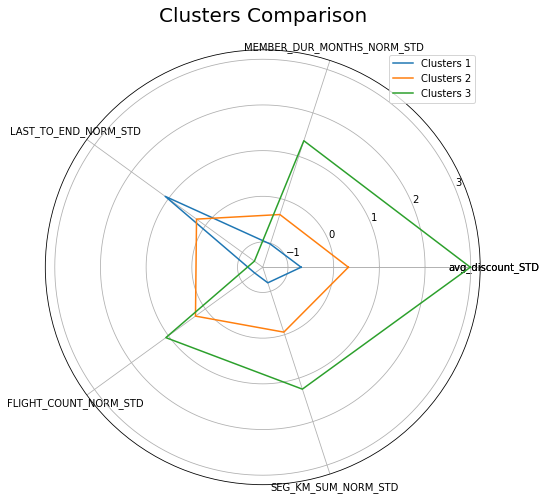

In [52]:
categories = list(df_radar)
categories = [*categories, categories[0]]

Clusters_1 = df_radar.loc[0].values.tolist()
Clusters_2 = df_radar.loc[1].values.tolist()
Clusters_3 = df_radar.loc[2].values.tolist()
Clusters_1 = [*Clusters_1, Clusters_1[0]]
Clusters_2 = [*Clusters_2, Clusters_2[0]]
Clusters_3 = [*Clusters_3, Clusters_3[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(Clusters_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, Clusters_1, label='Clusters 1')
plt.plot(label_loc, Clusters_2, label='Clusters 2')
plt.plot(label_loc, Clusters_3, label='Clusters 3')
plt.title('Clusters Comparison', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

#### Cluster 1

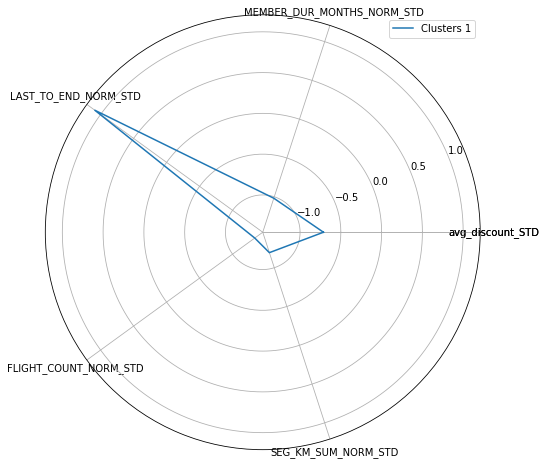

In [53]:
Clusters_1 = df_radar.loc[0].values.tolist()
Clusters_1 = [*Clusters_1, Clusters_1[0]]

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, Clusters_1, label='Clusters 1')
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

#### Cluster 2

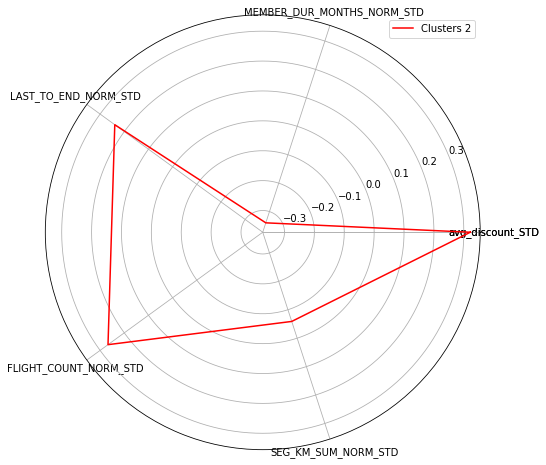

In [54]:
plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, Clusters_2, label='Clusters 2', color='red')
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

#### Cluster 3

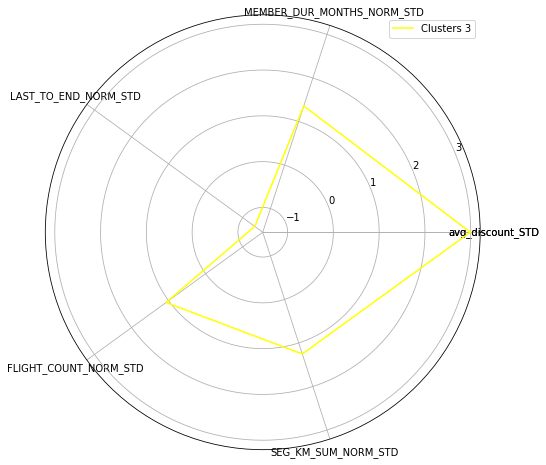

In [55]:
plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, Clusters_3, label='Clusters 3', color='yellow')
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

# Conclusion

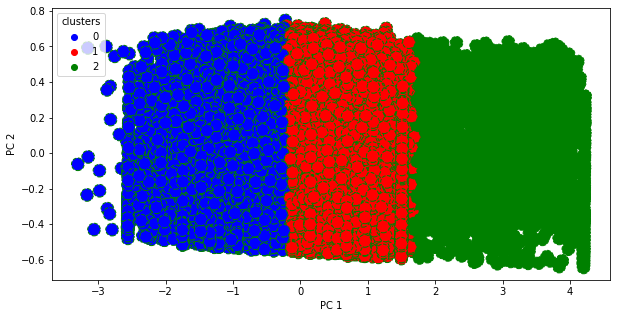

In [56]:
fig, ax = plt.subplots(figsize=(10,5))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="clusters",
    edgecolor='green',
    linestyle='--',
    data=data_pca,
    palette=['blue','red','green'],
    s=160,
    ax=ax
)

plt.show()

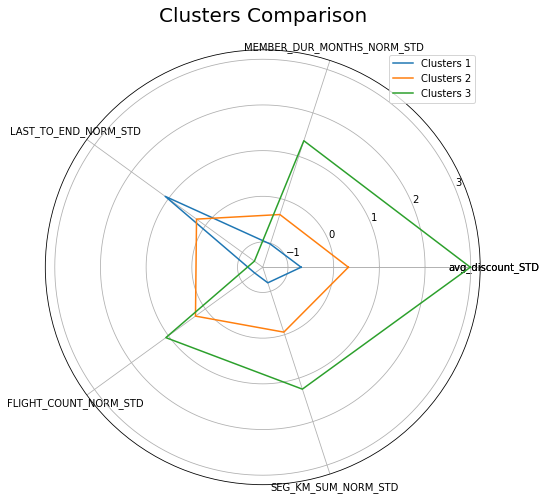

In [57]:
categories = list(df_radar)
categories = [*categories, categories[0]]

Clusters_1 = df_radar.loc[0].values.tolist()
Clusters_2 = df_radar.loc[1].values.tolist()
Clusters_3 = df_radar.loc[2].values.tolist()
Clusters_1 = [*Clusters_1, Clusters_1[0]]
Clusters_2 = [*Clusters_2, Clusters_2[0]]
Clusters_3 = [*Clusters_3, Clusters_3[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(Clusters_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, Clusters_1, label='Clusters 1')
plt.plot(label_loc, Clusters_2, label='Clusters 2')
plt.plot(label_loc, Clusters_3, label='Clusters 3')
plt.title('Clusters Comparison', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

In [58]:
data[rfmlc].groupby('clusters').median()

,MEMBER_DUR_MONTHS,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,avg_discount
clusters,,,,,
0,39.0,115.0,6.0,9133.0,0.590000
1,43.0,102.0,8.0,10876.5,0.781153
2,53.0,78.0,9.0,12891.5,1.274090


From the summary and visualization above we could conclude there are 3 clusters created on this modelling which is :
1. Cluster 0 (low-level customers) : 
It shows this cluster have highest `LAST_TO_END` which means this kind of customers have longest recency than other two. In the term of membership, this customers have shortest `MEMBER_DUR_MONTHS` which means either this customers are new membership or just old member whom churned from the company. Meanwhile, the three other columns have smallest values than others indicate the class and also the segmentation for this cluster. The company need to formulate new marketing strategy in order to increase transaction from this cluster.

2. Cluster 1 (middle-level customers) :
The Cluster 1 absolutely stand on the middle of the crowds in every columns. This means this kind of customers stand between the low-level and high-level customers with all columns have middle values from all cluster members. The company just need to maintain the customers to encourage them in order raised the transactions

3. Cluster 2 (high-level customers) :
Now we move to the highest level customers. No doubt that these customers contribute mostly to the company. Loyal customers determine by `MEMBER_DUR_MONTHS` and also high recency by `LAST_TO_END` shows how these customers believe in company. `avg_discount` also show the higher buying power than other two clusters. The company must improve their satisfaction because indeed these customers is main power of the company.